In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from routines import xzload

pd.set_option('display.max_rows', None)

Load the dataset. Note that "country" is included but has not been transformed

In [2]:
interest_cols = [
    'salary',
    'satisfaction',
    'age',
    'gender',
    'years_coding',
    'occupation',
    'employment',
    'industry',
    'org_size',
    'job_seek',
    'remote',
    'education',
    'undergrad',
    'os',
]

df = xzload("surveys.pz")

In [3]:
df.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
age,295531.0,30.248505,9.062109,1.0,23.0,29.0,34.0,279.0
education_associate_degree,252199.0,0.030734,0.172596,0.0,0.0,0.0,0.0,1.0
education_bachelors,385707.0,0.408953,0.491641,0.0,0.0,0.0,1.0,1.0
education_bootcamp,321246.0,0.081579,0.273723,0.0,0.0,0.0,0.0,1.0
education_college,385707.0,0.130965,0.337362,0.0,0.0,0.0,0.0,1.0
education_competition,239130.0,0.186911,0.389841,0.0,0.0,0.0,0.0,1.0
education_doctoral,385707.0,0.023391,0.151141,0.0,0.0,0.0,0.0,1.0
education_elementary,303591.0,0.016687,0.128096,0.0,0.0,0.0,0.0,1.0
education_hackathon,239130.0,0.196366,0.397249,0.0,0.0,0.0,0.0,1.0
education_industry_cert,321246.0,0.095818,0.294341,0.0,0.0,0.0,0.0,1.0


In [5]:
occ_cols = [col for col in df.columns if col.startswith("occupation")]
df[["survey_year"] + occ_cols].groupby('survey_year').mean().T

survey_year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
occupation_QA,NaN,NaN,NaN,NaN,0.006287,0.006764,0.024362,0.062657,0.071543,0.061231
occupation_academic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036832,0.116929,0.099300
occupation_admin,0.030217,0.023546,0.022993,0.020542,0.013187,0.013296,0.079507,0.104952,0.100458,0.081320
occupation_analyst,0.019197,0.016659,NaN,NaN,NaN,0.010173,NaN,0.076466,0.070812,0.062425
occupation_data_engineer,NaN,NaN,NaN,NaN,0.006862,0.006996,NaN,NaN,0.089050,0.079862
occupation_data_scientist,NaN,NaN,NaN,NaN,0.021237,0.021149,0.069953,0.071701,0.072680,0.061867
occupation_database,0.008176,0.005766,0.006569,0.007981,0.004562,0.004605,0.101027,0.133691,0.107107,0.088767
occupation_designer,NaN,NaN,NaN,NaN,0.005750,0.005943,0.027748,0.121582,0.103304,0.082546
occupation_devOps,NaN,NaN,NaN,0.016093,0.012344,0.019168,0.078125,0.096596,0.099704,0.092599
occupation_dev_desktop,0.148951,0.123979,0.095360,0.094335,0.066511,0.060503,0.203047,NaN,0.194818,0.182808


In [31]:
edu_cols = [col for col in df.columns if col.startswith("education")]
df[["survey_year"] + edu_cols].groupby('survey_year').mean().T

survey_year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
education_associate_degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030044,0.033055,0.028591
education_bachelors,NaN,NaN,NaN,NaN,0.307981,0.334785,0.420474,0.441647,0.440287,0.411753
education_bootcamp,NaN,NaN,NaN,NaN,0.028176,0.050312,0.053063,0.070679,0.145573,NaN
education_college,NaN,NaN,NaN,NaN,0.136088,0.167482,0.158176,0.118456,0.118155,0.112300
education_competition,NaN,NaN,NaN,NaN,NaN,NaN,0.130040,0.167194,0.241722,NaN
education_doctoral,NaN,NaN,NaN,NaN,0.017596,0.016402,0.025451,0.022396,0.027362,0.026217
education_elementary,NaN,NaN,NaN,NaN,NaN,NaN,0.020373,0.016752,0.015999,0.014598
education_hackathon,NaN,NaN,NaN,NaN,NaN,NaN,0.139127,0.180790,0.246785,NaN
education_industry_cert,NaN,NaN,NaN,NaN,0.050104,0.053578,0.087017,0.094401,0.142524,NaN
education_master,NaN,NaN,NaN,NaN,0.150579,NaN,NaN,NaN,NaN,NaN


In [6]:
sorted(list(pd.unique(df["country"].dropna())))

['Afghanistan',
 'Africa',
 'Aland Islands',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua & Deps',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australasia',
 'Australia',
 'Austria',
 'Azerbaidjan',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia Herzegovina',
 'Bosnia and Herzegovina',
 'Bosnia-Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'Brunei',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Rep',
 'Central African Republic',
 'Central America',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Colombia',
 'Comoros',
 'Congo {Democratic Rep}',
 'Congo, Republic of the...',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',


In [7]:
G7 = [
    "Canada",
    "France",
    "Germany",
    "Italy",
    "Japan",
    "United Kingdom",
    "United States"
]

G20 = [
    "Argentina",
    "Australia",
    "Brazil",
    "Canada",
    "China",
    "France",
    "Germany",
    "India",
    "Indonesia",
    "Italy",
    "Japan",
    "Mexico",
    "Russia",
    "Saudi Arabia",
    "South Africa",
    "South Korea",
    "Turkey",
    "United Kingdom",
    "United States",
    "Spain"
]

dc = df[df.country.isin(G7)]

In [8]:
dp = pd.pivot_table(dc, values='salary', index='survey_year', columns=['country'])
dp

country,Canada,France,Germany,Italy,Japan,United Kingdom,United States
survey_year,,,,,,,
2011,54453.781513,46938.775510,42985.074627,34000.000000,NaN,59196.787149,67136.038186
2012,57272.727273,45176.470588,49769.230769,34179.104478,NaN,59048.913043,63218.574860
2013,54591.836735,48888.888889,50798.479087,37066.666667,NaN,61771.653543,68845.043311
2014,55464.480874,43181.818182,51174.089069,31029.411765,49000.000000,60367.346939,66991.814461
2015,53752.310536,41716.101695,45998.013903,31524.163569,49210.526316,59638.069705,73529.772867
2016,65091.443501,51642.241379,58491.091314,56170.468187,63661.417323,69449.259156,95017.853873
2017,56924.889828,42879.033385,51616.301032,31255.036060,40795.413622,52602.396967,96194.754635
2018,100894.343419,89410.899793,91850.611243,95691.657754,81066.321637,128216.930944,154413.128506
2019,134018.564909,81214.779722,109256.884066,89535.843882,88246.288462,166182.499504,249546.254589


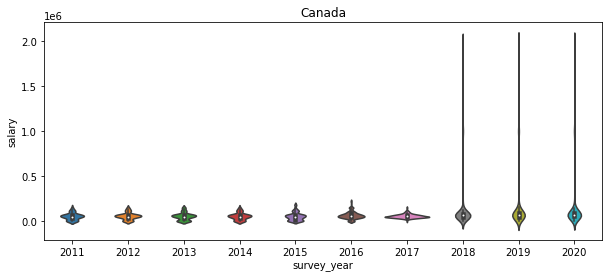

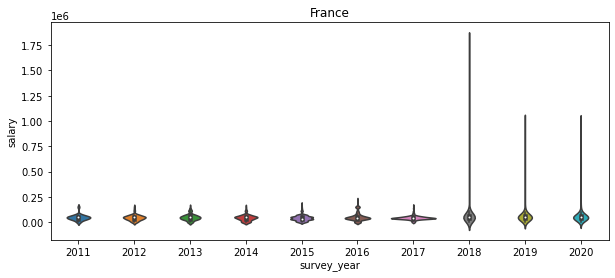

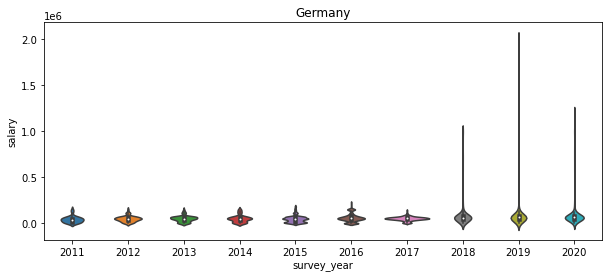

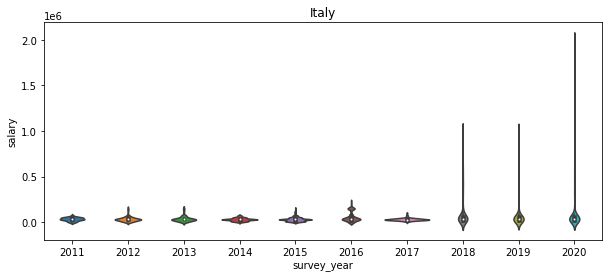

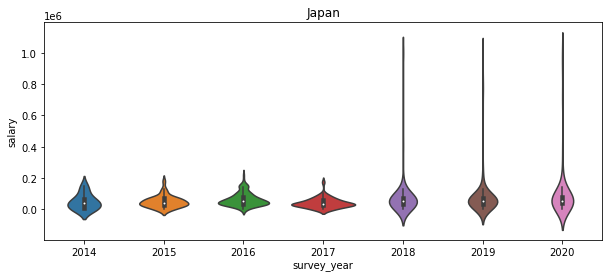

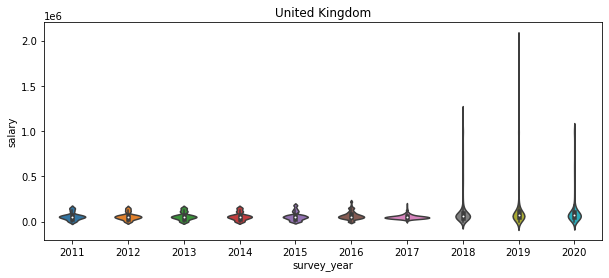

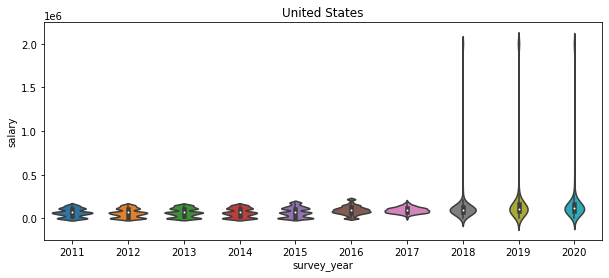

In [25]:
for country in G7:
    fig=plt.figure()
    sns.violinplot(x='survey_year',y='salary',data=dc.loc[dc.country==country])
    plt.title(country)